# DENTAL SOLUTION

In [1]:
import skimage.io
import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate
import slgbuilder
np.bool = bool


# Investigate data

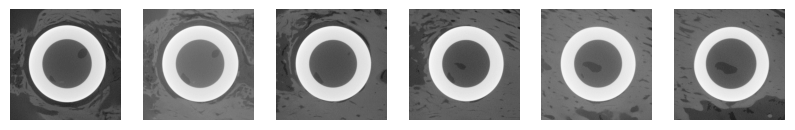

In [2]:
V = skimage.io.imread('../data/week7/dental_slices.tif')
fig, ax = plt.subplots(1, len(V), figsize=(10, 5))
for a, v in zip(ax, V):
    a.imshow(v, cmap='gray')
    a.axis('off')

## Unfold, solve, and quantify

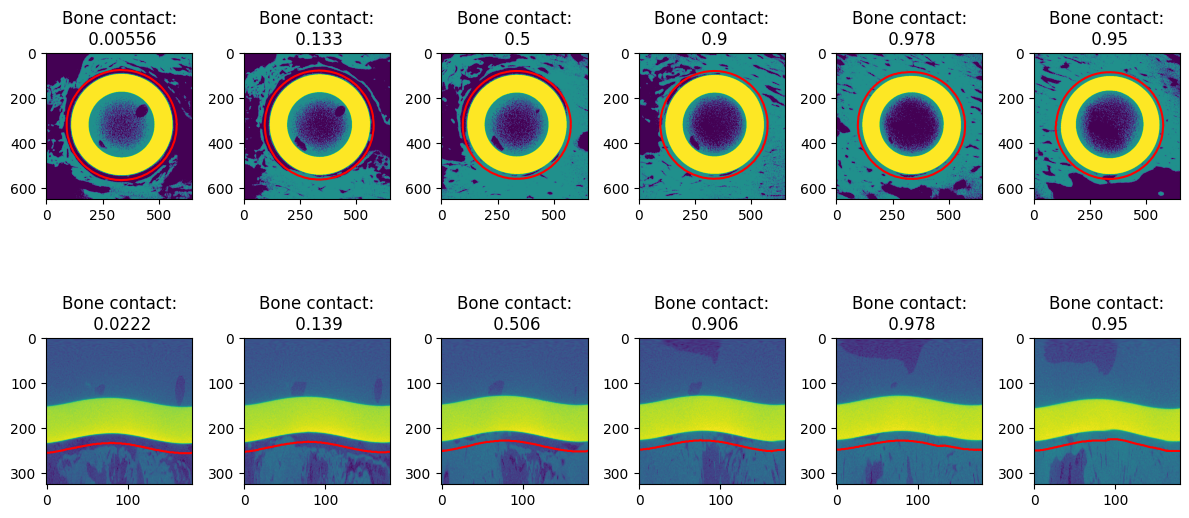

In [3]:
fig, ax = plt.subplots(2, len(V), figsize=(12, 6))

# Setttings for unfolding.
a = 180  # number of angles for unfolding
angles = np.linspace(0, 2 * np.pi, a, endpoint=False)  # angular coordinate
center = (np.array(V.shape[1:]) - 1) / 2
radii = np.arange(min(V.shape[1:]) / 2) + 1  # radial coordinate for unwrapping
X = center[0] + np.outer(radii, np.cos(angles))
Y = center[1] + np.outer(radii, np.sin(angles))
grid = np.stack((Y.ravel(), X.ravel()), axis=1)

#  Settings for cut
delta = 2

for i, I in enumerate(V):
    
    # Unfolding 
    F = scipy.interpolate.RectBivariateSpline(np.arange(I.shape[0]), np.arange(I.shape[1]), I)
    #val = F(snake[:, 0], snake[:, 1], grid=False)
    U = F(grid[:, 0], grid[:, 1], grid=False).reshape((len(radii), a))
    
    # Cost, making it int32
    cost = np.diff(U.astype(float), axis=0)
    cost = np.minimum(cost, 0) 
    cost -= cost.min()
    cost /= cost.max()
    cost *= (2 ** 16) - 1
    cost = cost.astype(np.int32)

    # Cut
    layer = slgbuilder.GraphObject(cost)
    helper = slgbuilder.MaxflowBuilder()
    helper.add_object(layer)
    helper.add_layered_boundary_cost()
    helper.add_layered_smoothness(delta=delta, wrap=True)
    
    helper.solve()
    segmentation = helper.what_segments(layer)
    r0 = segmentation.sum(axis=0) - 0.5 # not 1 because diff 
       
    # Expanding 20 pixels and folding back
    r20 = r0 + 20
    x20 = center[0] + r20 * np.cos(angles)
    y20 = center[1] + r20 * np.sin(angles)
    
    S = (I > 200).astype(int) + (I > 110).astype(int)
    ax[0, i].imshow(S)
    ax[0, i].plot(x20, y20, 'r')

    ax[1, i].imshow(U)
    ax[1, i].set_aspect(a/len(radii))
    ax[1, i].plot(r20, 'r')
    
    # Getting contact values
    contact_from_image = (F(y20, x20, grid=False) > 110).mean()
    ax[0, i].set_title(f'Bone contact:\n {contact_from_image:0.3g}')
    contact_from_unfolded = (U[r20.astype(int), np.arange(len(r20))] > 110).mean()
    ax[1, i].set_title(f'Bone contact:\n {contact_from_unfolded:0.3g}')

    
fig.tight_layout()
plt.show()
